In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
import multivariatet as mt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

## read in data

In [9]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

n,d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])

## kernel generation functions

In [3]:
# def old_generate_kernel(m=50, q=10, s=1/d):
#     q_arr = np.random.uniform(low=0.5, high=4, size=q) # multipliers for size of domain of inner uniform distribution
#     std = np.sqrt(2*s)
#     W = np.random.uniform(low=-std*q_arr, high=std*q_arr, size=(m,d,q)).transpose(2,0,1) # (q,m,d)
#     b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    
#     def ker(x, y):
#         sum_ = 0
#         for i in range(q):
#             z1 = np.cos(x @ W[i].T + b)
#             z2 = np.cos(y @ W[i].T + b)
#             sum_ += z1 @ z2.T
#         return (sum_ / (m*q))
    
#     return ker

In [14]:
def generate_kernel(m=40, q=10, s=1/d):
    q_arr = np.random.uniform(low=0.5, high=4, size=q) # multipliers for size of domain of inner uniform distribution
    std = np.sqrt(2*s)
    W = np.random.uniform(low=-std*q_arr, high=std*q_arr, size=(m,d,q))
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m,1))
    
    def ker(x, y):
        z1 = np.cos(np.dot(x, W) + b)
        z2 = np.cos(np.dot(y, W) + b)
        res = np.tensordot(z1, z2, axes=([1,2],[1,2])) / (m*q)
        return res
            
    return ker

In [15]:
# random_svm = SVC(kernel=old_generate_kernel())
# random_svm.fit(X_train, y_train)
# old_score = random_svm.score(X_test, y_test)
# print(old_score)

In [16]:
random_svm = SVC(kernel=generate_kernel())
random_svm.fit(X_train, y_train)
score = random_svm.score(X_test, y_test)
print(score)

0.77


    x: test, d
    y: train, d
    W: q, m, d ---- m, d, q
    b: 1, m
    z1: test, m ---- test, m, q
    z2: train, m ---- train, m, q
    res: test, train

## experiments

In [17]:
iterations = 100
scores = np.empty((iterations))
    

for i in trange(iterations):
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(X_train, y_train)
    scores[i] = random_svm.score(X_test, y_test)

stat = np.empty((7, iterations))
stat[0] = np.min(scores)
stat[1] = np.quantile(scores, 0.25)
stat[2] = np.median(scores)
stat[3] = np.quantile(scores, 0.75)
stat[4] = np.max(scores)
stat[5] = np.mean(scores)
stat[6] = np.std(scores)

100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


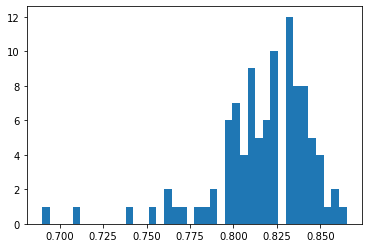

In [44]:
plt.hist(scores, bins=40);

In [ ]:
# large_X = full_X[:10000]
# large_y = full_y[:10000]
# large_X_train, large_X_test, large_y_train, large_y_test = train_test_split(large_X, large_y, test_size=0.2, random_state=15)

In [ ]:
# start = perf_counter()
# svm = SVC(gamma='auto')
# svm.fit(large_X_train, large_y_train)
# det_score = svm.score(large_X_test, large_y_test)
# end = perf_counter()
# det_time = end - start


# iterations = 100
# scores = np.empty(iterations)
# times = np.empty(iterations)

# for i in tqdm(range(iterations)):
#     start = perf_counter()
#     random_svm = SVC(kernel=generate_kernel())
#     random_svm.fit(large_X_train, large_y_train)
#     end = perf_counter()
#     times[i] = end - start
#     scores[i] = random_svm.score(large_X_test, large_y_test)

In [ ]:
# print(f'Gaussian kernel: Accuracy: {det_score}, time: {det_time}')
# print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
# print(f'Acc. stats: Q0: {np.min(scores)}, Q1: {np.quantile(scores, 0.25)}, Q2: {np.median(scores)}, Q3: {np.quantile(scores,0.75)}, Q4: {np.max(scores)}')

In [ ]:
# test = np.random.uniform(low=[1,10,100], high=[2,20,200], size=(1,2,3)).transpose(2,0,1)
# test

In [ ]:
# test.shape